In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")   ##### ignore warnings 

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
#read data
ts_data = pd.read_csv('./data/1-retail_daily_amount.csv', index_col='Date', parse_dates=True)
log_data = pd.read_csv('./data/2-retail_daily_amount_log.csv', index_col='Date', parse_dates=True)
log_data_r_mean = pd.read_csv('./data/2-retail_daily_amount_log_r_mean.csv', index_col='Date', parse_dates=True)
log_returns = pd.read_csv('./data/2-retail_daily_amount_log_returns.csv', index_col='Date', parse_dates=True)
df_diff = pd.read_csv('./data/2-retail_daily_amount_diff.csv', index_col='Date', parse_dates=True)

In [3]:
# fix seed to make sure it is reproducible
np.random.seed(123)

# Rebuild SARIMA model

The ARCH/GARCH models will run over the based SARIMA(2,0,0)(2,1,1)[12] model with smoothed data (log_data_r_mean) from the "3-Model_ARMA_ARIMA_SARIMA" notebook, as it found the best performance between our tests

In [4]:
data=np.exp(log_data_r_mean)

In [5]:
# Create Training and Test
data=data['Amount']

train_data = data[:417]
test_data = data[417:]

In [6]:
# Let's fit this model
mod = SARIMAX(train_data,order=(2,0,0),seasonal_order=(2,1,1,12))

results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               Amount   No. Observations:                  417
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood               -3906.813
Date:                              Sat, 19 Jun 2021   AIC                           7825.626
Time:                                      16:31:50   BIC                           7849.650
Sample:                                           0   HQIC                          7835.135
                                              - 417                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2256      0.038     32.579      0.000       1.152       1.299
ar.L2         -0.2974      0.040     -7.464      0.000      -0.375      -0.219
ar.S.L12       0.0018      0.070      0.026      0.979      -0.136       0.140
ar.S.L24       0.1665      0.060      2.766      0.006       0.049       0.284
ma.S.L12      -0.7970      0.060    -13.297      0.000      -0.915      -0.680
sigma2      1.361e+07   2.26e-09   6.02e+15      0.000    1.36e+07    1.36e+07
===================================================================================
Ljung-Box (Q):                       89.77   Jarque-Bera (JB):               638.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.69
Prob(H) (two-sided):                  0.07   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.73e+31. Standard errors may be unstable.
"""

# ARCH Models

## ARCH-LM Test on the SARIMA residuals

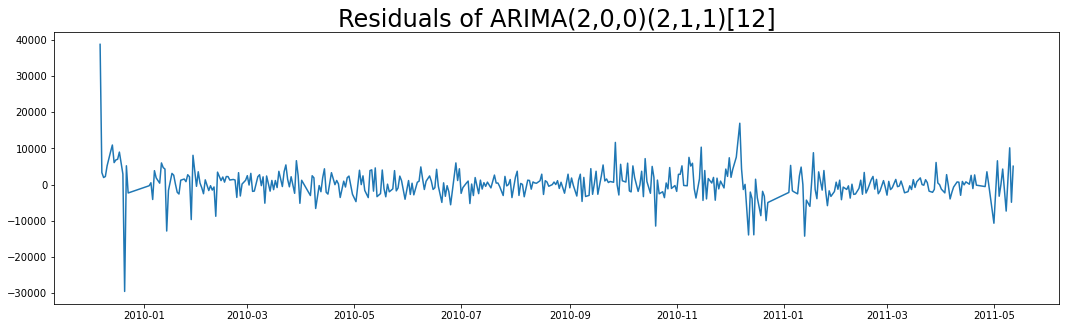

In [7]:
# Set the figure size
plt.rcParams["figure.figsize"] = 18, 5
# Plotting residuals
plt.plot(results.resid, label = "Residuals")
# Setting Title
plt.title("Residuals of ARIMA(2,0,0)(2,1,1)[12]", size = 24)
# Display the plot
plt.show()

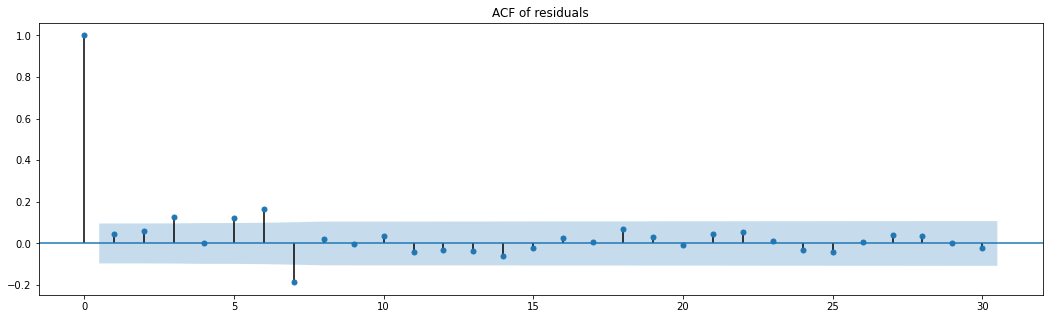

In [8]:
plot_acf(results.resid, lags=30, alpha=0.05, title="ACF of residuals")
plt.show()

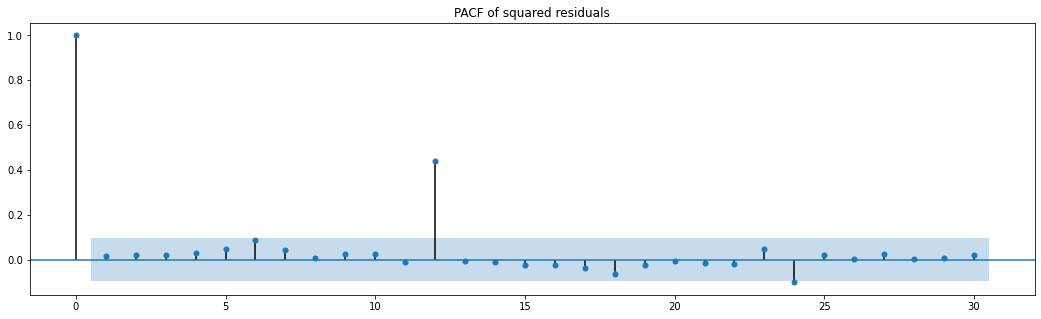

In [9]:
plot_pacf(results.resid**2, lags=30, alpha=0.05, title="PACF of squared residuals")
plt.show()

Now we will apply the LM-ARCH test in order to identify Heteroskedasticity on residuals

In [10]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(results.resid, maxlag=50)

print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')

Lagrange mulitplier p-value: 8.434589069612125e-05
F test p-value: 1.2954025422680183e-05


Both p-value are smaller than 0.05 we reject the null hypothesis that residuals are white noise, it points to heteroskedasticity. So we will check the ARCH and GARCH modelos

## ARCH model

As the ARCH-LM test has indicated that the variance in the series is autocorrelated, it makes sense to
apply the ARCH and GARCH models, and some of their variations, to our time series of smoothed log values.

In [11]:
# Importing required package
from arch import arch_model

resid_model_arch = arch_model(results.resid, p = 1, vol = "ARCH")
# Fitting (Training) the model
resid_model_arch_results = resid_model_arch.fit()
# Displaying the model summary
resid_model_arch_results.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4062.9337853104944
Iteration:      2,   Func. Count:     11,   Neg. LLF: 4054.3690809462887
Iteration:      3,   Func. Count:     15,   Neg. LLF: 4054.368802103267
Iteration:      4,   Func. Count:     19,   Neg. LLF: 4054.3683749194715
Iteration:      5,   Func. Count:     23,   Neg. LLF: 4054.366923550822
Iteration:      6,   Func. Count:     27,   Neg. LLF: 4054.363364784562
Iteration:      7,   Func. Count:     31,   Neg. LLF: 4054.3538485292584
Iteration:      8,   Func. Count:     35,   Neg. LLF: 4054.328604304808
Iteration:      9,   Func. Count:     39,   Neg. LLF: 4054.2654044932883
Iteration:     10,   Func. Count:     43,   Neg. LLF: 4054.089998454449
Iteration:     11,   Func. Count:     47,   Neg. LLF: 4053.653254123304
Iteration:     12,   Func. Count:     51,   Neg. LLF: 4052.8250434744677
Iteration:     13,   Func. Count:     55,   Neg. LLF: 4051.9749252748024
Iteration:     14,   Func. Count:     59,   Neg. LLF: 405

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                      -0.010
Mean Model:             Constant Mean   Adj. R-squared:                 -0.010
Vol Model:                       ARCH   Log-Likelihood:               -4051.60
Distribution:                  Normal   AIC:                           8109.20
Method:            Maximum Likelihood   BIC:                           8121.29
                                        No. Observations:                  417
Date:                Sat, Jun 19 2021   Df Residuals:                      414
Time:                        16:31:52   Df Model:                            3
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu          -147.3901    262.495     -0.561      0.574 [-6.619e+02,3.671e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.2396e+07  2.432e+06      5.096  3.468e-07 [7.628e+06,1.716e+07]
alpha[1]       0.4565      0.263      1.734  8.289e-02  [-5.944e-02,  0.972]
============================================================================

Covariance estimator: robust
"""

In [12]:
arch_bic = resid_model_arch_results.bic

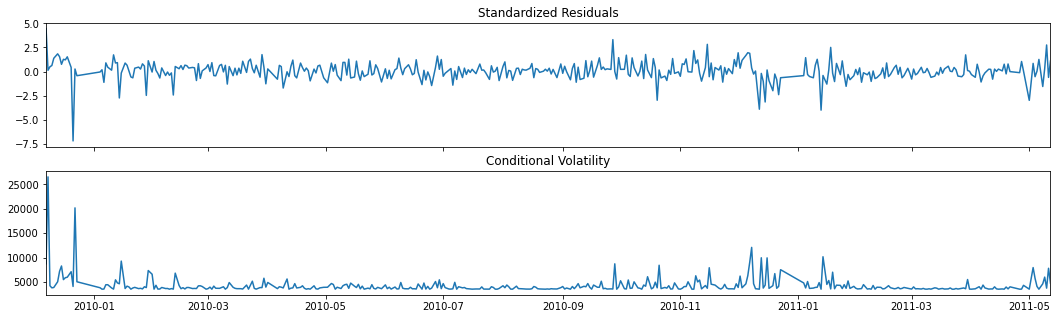

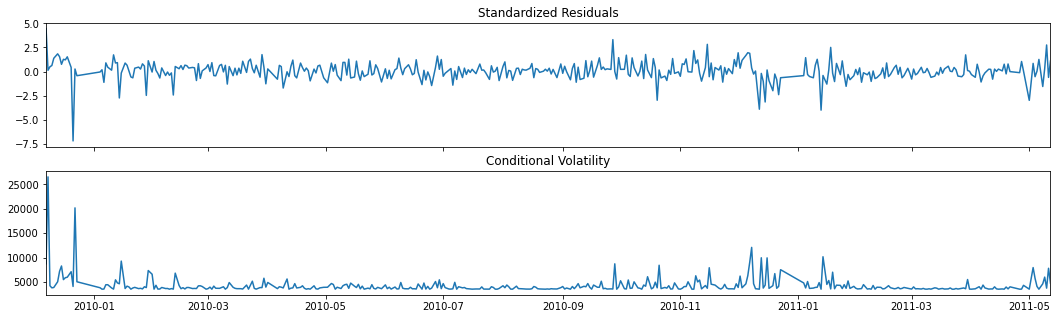

In [13]:
resid_model_arch_results.plot()

## GARCH model of order (1,1) with TStudents distribution

The GARCH(p,q) model is a generalization version of the ARCH. With a GARCH, it is possible to model the mean by including an ARMA order and also the variance (volatility), where p express the lags of conditional variance in the equation. A GARCH(0,q) model is equivalent to ARCH(q).

For the variance component, we have defined the order GARCH(1,1) as it is usually enough. Despite being a simple model, it is able to capture the most common scenarios regarding volatility (as heavy tails and clustering) and, historically, its predictions have a good performance.

In [14]:
# Importing required package
from arch import arch_model

resid_model_garch_Studentst = arch_model(results.resid, p = 1, q = 1 , vol = "GARCH", dist='StudentsT')
# Fitting (Training) the model
resid_model_garch_Studentst_results = resid_model_garch_Studentst.fit()
# Displaying the model summary
resid_model_garch_Studentst_results.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5062.19833843685
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3980.9278202130185
Iteration:      3,   Func. Count:     23,   Neg. LLF: 4337.966149200227
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3978.2418816378304
Iteration:      5,   Func. Count:     37,   Neg. LLF: 3978.847560328556
Iteration:      6,   Func. Count:     44,   Neg. LLF: 3977.94509242526
Iteration:      7,   Func. Count:     50,   Neg. LLF: 3977.9431047121498
Iteration:      8,   Func. Count:     56,   Neg. LLF: 3977.9429092750415
Iteration:      9,   Func. Count:     62,   Neg. LLF: 3977.94253751862
Iteration:     10,   Func. Count:     68,   Neg. LLF: 3977.9412940783373
Iteration:     11,   Func. Count:     74,   Neg. LLF: 3977.9383134152586
Iteration:     12,   Func. Count:     80,   Neg. LLF: 3977.9306697120137
Iteration:     13,   Func. Count:     86,   Neg. LLF: 3977.9104365430476
Iteration:     14,   Func. Count:     92,   Neg. LLF: 3977.

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -3976.72
Distribution:      Standardized Student's t   AIC:                           7963.44
Method:                  Maximum Likelihood   BIC:                           7983.60
                                              No. Observations:                  417
Date:                      Sat, Jun 19 2021   Df Residuals:                      412
Time:                              16:31:53   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            69.4223    141.405      0.491      0.623 [-2.077e+02,3.466e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.8142e+05  1.734e+05      2.200  2.779e-02 [4.164e+04,7.212e+05]
alpha[1]       0.1072  3.445e-02      3.112  1.857e-03   [3.969e-02,  0.175]
beta[1]        0.8630  2.439e-02     35.384 2.967e-274     [  0.815,  0.911]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.0315      1.044      4.820  1.435e-06 [  2.986,  7.077]
========================================================================

Covariance estimator: robust
"""

In [15]:
garch_T_bic = resid_model_garch_Studentst_results.bic

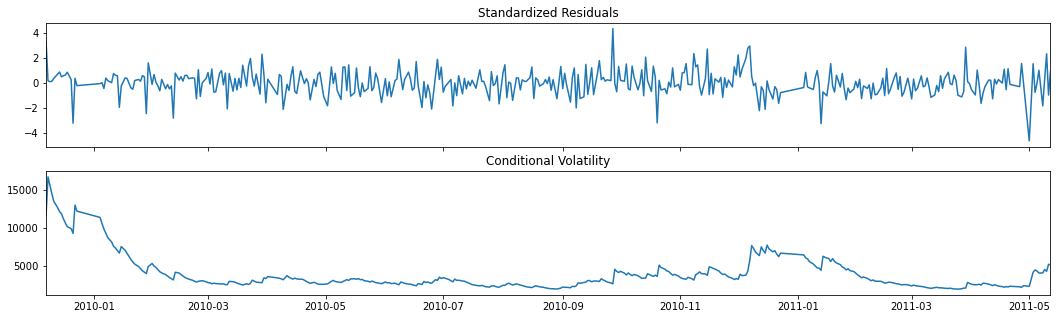

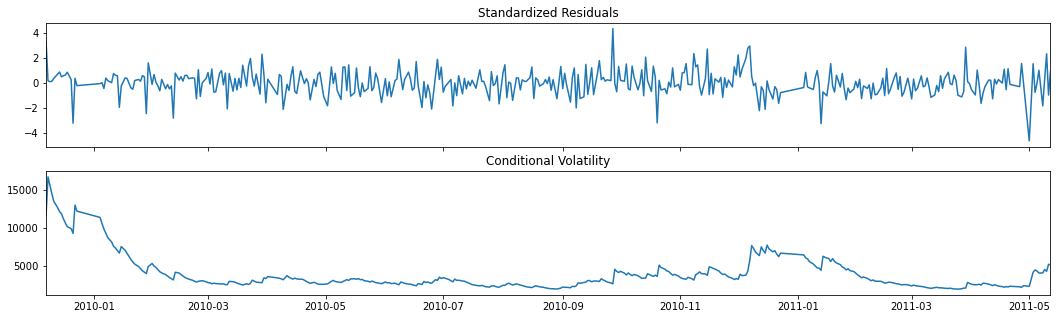

In [16]:
resid_model_garch_Studentst_results.plot()

## EGARCH model of order (1,1) with TStudents distribution

As GARCH always has an asymmetric response, due to the terms being squared based on its restrictions, it is not possible to distinguish between positive and negative shocks. This happening, the leverage impact of negative data will not be feasibly modelated. To accommodate this feature, the EGARCH model adds an asymmetry coefficient, which allows not only to keep the asymmetry but also to remove this restriction from the GARCH model.

In [17]:
# Importing required package
from arch import arch_model

resid_model_egarch_Studentst = arch_model(results.resid, p = 1, q = 1 , vol = "EGARCH", dist='StudentsT')
# Fitting (Training) the model
resid_model_egarch_Studentst_results = resid_model_egarch_Studentst.fit()
# Displaying the model summary
resid_model_egarch_Studentst_results.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6681.803695905395
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7907.78181989034
Iteration:      3,   Func. Count:     26,   Neg. LLF: 9899.079828633194
Iteration:      4,   Func. Count:     33,   Neg. LLF: 9903.34325831288
Iteration:      5,   Func. Count:     40,   Neg. LLF: 6649.900199266474
Iteration:      6,   Func. Count:     48,   Neg. LLF: 20120.34244703914
Iteration:      7,   Func. Count:     55,   Neg. LLF: 19392.977433804022
Iteration:      8,   Func. Count:     62,   Neg. LLF: 4057.5782709984232
Iteration:      9,   Func. Count:     69,   Neg. LLF: 3994.5645557458092
Iteration:     10,   Func. Count:     75,   Neg. LLF: 3993.5206896457657
Iteration:     11,   Func. Count:     81,   Neg. LLF: 3992.7444169023584
Iteration:     12,   Func. Count:     87,   Neg. LLF: 3991.894752718319
Iteration:     13,   Func. Count:     93,   Neg. LLF: 3992.036111709993
Iteration:     14,   Func. Count:    100,   Neg. LLF: 3991.42

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - EGARCH Model Results                        
====================================================================================
Dep. Variable:                         None   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                           EGARCH   Log-Likelihood:               -3991.05
Distribution:      Standardized Student's t   AIC:                           7992.09
Method:                  Maximum Likelihood   BIC:                           8012.26
                                              No. Observations:                  417
Date:                      Sat, Jun 19 2021   Df Residuals:                      412
Time:                              16:31:54   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu           154.5400    138.491      1.116      0.264 [-1.169e+02,4.260e+02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          7.5533      2.133      3.541  3.988e-04 [  3.372, 11.734]
alpha[1]       0.3982  9.362e-02      4.254  2.103e-05 [  0.215,  0.582]
beta[1]        0.5470      0.125      4.364  1.279e-05 [  0.301,  0.793]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.3917      0.610      5.565  2.626e-08 [  2.197,  4.586]
========================================================================

Covariance estimator: robust
"""

In [18]:
egarch_T_bic = resid_model_egarch_Studentst_results.bic

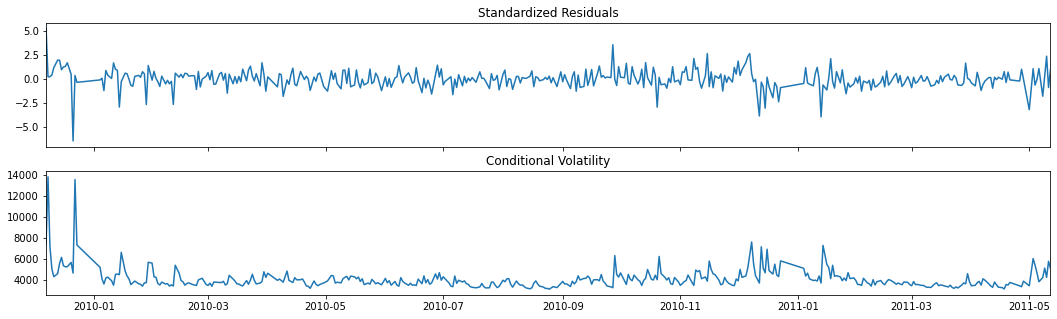

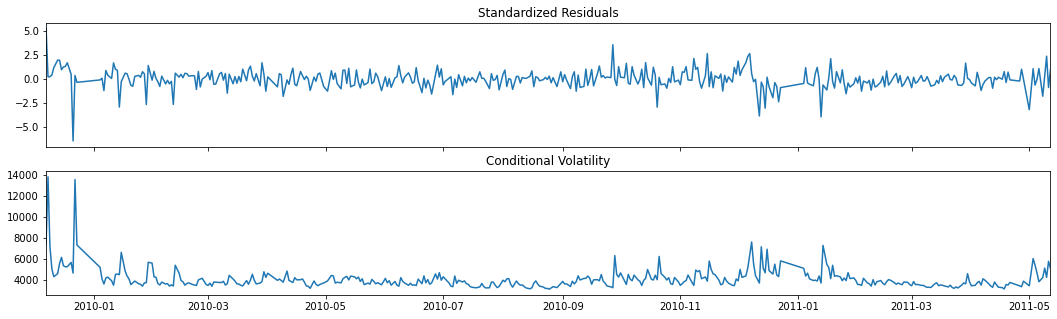

In [19]:
resid_model_egarch_Studentst_results.plot()

## GJR-GARCH model of order (1,1) with TStudents distribution

The GJR-GARCH assumes a dummy variable as an alternative to better model the negative and positive shocks. Basically, when the volatility is negative it assigns 1, otherwise 0. By doing this, negative shocks will cause more volatility than positive ones.

In [20]:
# Importing required package
from arch import arch_model

resid_model_gjrgarch_Studentst = arch_model(results.resid, p = 1, q = 1, o = 1 , vol = "GARCH", dist='StudentsT')
# Fitting (Training) the model
resid_model_gjrgarch_Studentst_results = resid_model_gjrgarch_Studentst.fit()
# Displaying the model summary
resid_model_gjrgarch_Studentst_results.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 4607.460758862556
Iteration:      2,   Func. Count:     17,   Neg. LLF: 3978.1370957039003
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3978.4334688041386
Iteration:      4,   Func. Count:     33,   Neg. LLF: 3975.704464510596
Iteration:      5,   Func. Count:     41,   Neg. LLF: 4020.1175594913975
Iteration:      6,   Func. Count:     49,   Neg. LLF: 3973.63736192179
Iteration:      7,   Func. Count:     56,   Neg. LLF: 3973.6361577483385
Iteration:      8,   Func. Count:     63,   Neg. LLF: 3973.6352428272103
Iteration:      9,   Func. Count:     70,   Neg. LLF: 3973.634955675385
Iteration:     10,   Func. Count:     77,   Neg. LLF: 3973.634821920109
Iteration:     11,   Func. Count:     84,   Neg. LLF: 3973.63386463875
Iteration:     12,   Func. Count:     91,   Neg. LLF: 3973.6282886237723
Iteration:     13,   Func. Count:     98,   Neg. LLF: 3973.601676728491
Iteration:     14,   Func. Count:    105,   Neg. LLF: 3973.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                         None   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3972.78
Distribution:      Standardized Student's t   AIC:                           7957.56
Method:                  Maximum Likelihood   BIC:                           7981.76
                                              No. Observations:                  417
Date:                      Sat, Jun 19 2021   Df Residuals:                      411
Time:                              16:31:55   Df Model:                            6
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu           107.3691    138.129      0.777      0.437 [-1.634e+02,3.781e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.8142e+05  1.651e+05      2.310  2.091e-02 [5.774e+04,7.051e+05]
alpha[1]       0.1727  5.589e-02      3.090  1.999e-03   [6.317e-02,  0.282]
gamma[1]      -0.1407  5.626e-02     -2.500  1.241e-02  [ -0.251,-3.040e-02]
beta[1]        0.8667  2.921e-02     29.669 1.904e-193     [  0.809,  0.924]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.8659      1.467      4.000  6.344e-05 [  2.991,  8.740]
========================================================================

Covariance estimator: robust
"""

In [21]:
gjrgarch_T_bic = resid_model_gjrgarch_Studentst_results.bic

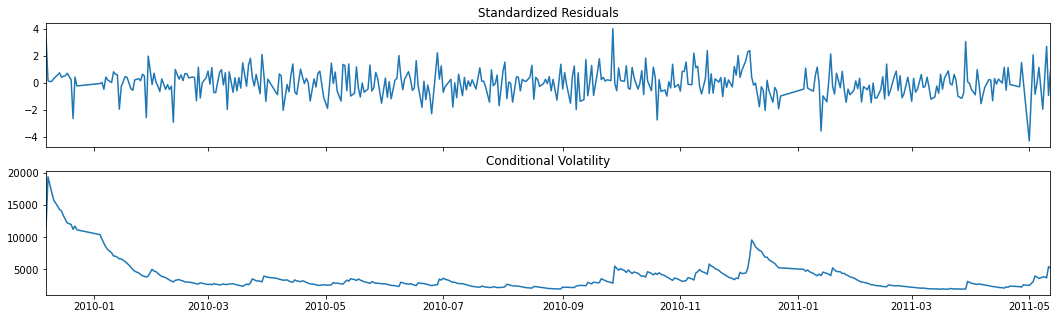

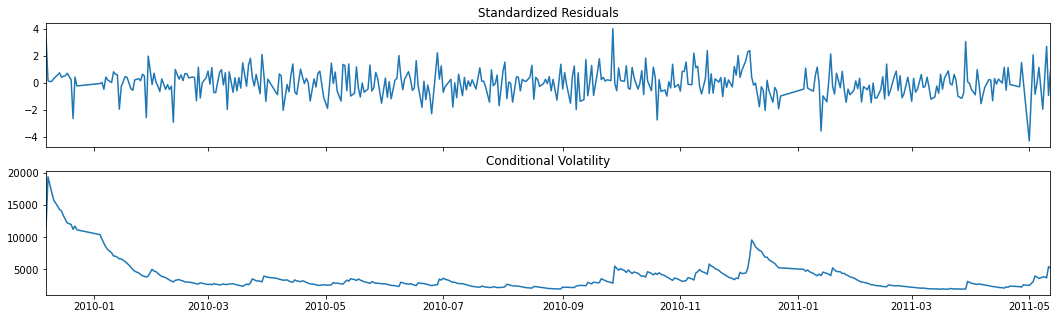

In [22]:
resid_model_gjrgarch_Studentst_results.plot()

## Comparison

In [23]:
#Compare bics and identify the smallest one
print("ARCH: ",arch_bic)
print("GARCH: ",garch_T_bic)
print("EGARCH: ",egarch_T_bic)
print("GJR-GARCH: ",gjrgarch_T_bic)

ARCH:  8121.294720316989
GARCH:  7983.604432280667
EGARCH:  8012.258416036977
GJR-GARCH:  7981.762922405636


Based on BIC the GJR-GARCH is the model that better explaing the variance on residuals